<img src="https://www.wellcomeconnectingscience.org/wp-content/themes/new_wellcome_connecting_science/dist/assets/svg/logo.svg" alt="WCS Logo" width="150" style="float: left;">
<img src="https://github.com/EveliaCoss/Tutorial_ISCB_LATAM_scATACseq/blob/main/Logo_JAGUAR.png?raw=true" alt="WCS Logo" width="150" style="float: right;">





# Analyzing PBMCs Single Cell ATAC- Seq (scATAC-Seq) and Multiome data: Theory and practice

## About the course 📌

This course is part of the Workshop [Single Cell Genomic Approaches to Study the Immune System - Latin America & the Caribbean](https://coursesandconferences.wellcomeconnectingscience.org/event/single-cell-genomic-approaches-to-study-the-immune-system-latin-america-the-caribbean-20241109/) (9-11 Novembrer 2024), Universidad CES, Medellín, Colombia.

- **Date:** 11 November 2024
- **Course duration**: 5 hours

**Speakers:**

- <font color='orange'>Diego Ramirez</font> - Bachelor in Genomic Sciences, Escuela Nacional de Estudios Superiores Unidad Juriquilla UNAM (ENES Juriquilla), Mexico.
- <font color='orange'>Evelia Lorena Coss-Navarrete</font> - PostDoc, International Laboratory for Human Genome Research (LIIGH)-UNAM, Mexico. Contact: [Web page](https://eveliacoss.github.io/)

### About datasets

For this tutorial, we will be analyzing a single-cell ATAC-seq dataset of [human peripheral blood mononuclear cells (PBMCs)](https://www.10xgenomics.com/datasets/1-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-next-gem-v-1-1-1-1-standard-1-1-0) provided by 10x Genomics (Next GEM v1.1). The following files are used in this course, all available through the 10x Genomics website:

- The Raw data: Filtered peak barcode matrix.

- The Metadata: Per-barcode fragment counts & metrics.

- The fragments file: Barcoded and aligned fragment file.

- The fragments file index: Fragments file index.

*   Github: https://github.com/EveliaCoss/Tutorial_ISCB_LATAM_scATACseq
*   Main page: https://eveliacoss.github.io/Tutorial_ISCB_LATAM_scATACseq/

# 1️⃣ **Practical 13: Pre-Processing and Quality Control, gene activity matrix approach**



## Settings 💻 <a name="setup"></a>

In this step, we will learn how to execute shell commands from within our R environment in Google Colab. This is particularly useful because the free version of Colab does not natively support showing shell command outputs when using the R kernel.



### 1) Executing Shell Commands in R

In [ ]:
# This is used to time the running of the notebook
start_time <- Sys.time()

In [ ]:
# @title 1.1) Using shell_call to Execute Shell Commands
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

loadPackages = function(pkgs){
  myrequire = function(...){
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(...))))
  }
  ok = sapply(pkgs, require, character.only=TRUE, quietly=TRUE)
  if (!all(ok)){
    message("There are missing packages: ", paste(pkgs[!ok], collapse=", "))
  }
}

In [ ]:
# @title 1.2) Setting Up R2U for Efficient Package Installation
# R2U (R to Ubuntu) provides a faster way to install R packages by leveraging the Ubuntu package manager.

## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")


53 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
ca-certificates is already the newest version (20240203~22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6pBh5No

Tracing function "install.packages" in package "utils"



### 2) Install Required Packages

In [ ]:
# Define the packages to install from CRAN and Bioconductor
cranPkgs <- c("BiocManager", "Seurat", "cowplot", "SingleCellExperiment", "scDblFinder", "Rtsne", "hdf5r", "clustree",
              "tidyverse", "Signac", "SeuratObject", "hdf5r", "reticulate", "patchwork", "ggplot2", "future")
biocPkgs <- c("celldex", "SingleR", "SeuratDisk", "clusterProfile", "preprocessCore", "EnsDb.Hsapiens.v86",
              "biovizBase", "LoomExperiment", "SingleCellExperiment")

# Install packages from CRAN
install.packages(cranPkgs, ask=FALSE, update=TRUE, quietly=TRUE)

# Install packages from Bioconductor
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}
BiocManager::install(biocPkgs)

# Install SeuratData and sceasy from GitHub
if (!requireNamespace("devtools", quietly = TRUE)) {
    install.packages("devtools")
}

devtools::install_github('satijalab/seurat-data')
devtools::install_github("cellgeni/sceasy")

# Verify and install SeuratData from Bioconductor if necessary
if (!requireNamespace("SeuratData", quietly = TRUE)) {
    BiocManager::install("SeuratData")
}

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'SingleCellExperiment'”
Installing package(s) 'BiocVersion', 'celldex', 'SingleR', 'SeuratDisk',
  'clusterProfile', 'preprocessCore', 'EnsDb.Hsapiens.v86', 'biovizBase',
  'LoomExperiment'

Warning message:
“packages ‘clusterProfile’, ‘SeuratDisk’ are not available for Bioconductor version '3.19'

Versions of these packages for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Old packages: 'edgeR', 'GenomicRanges', 'gert', 'rstudioapi'





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpVUHJOA/remotes2273d3e7b7e/satijalab-seurat-data-4dc08e0/DESCRIPTION’ ... OK
* preparing ‘SeuratData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratData_0.2.2.9001.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpVUHJOA/remotes2273bf2e536/cellgeni-sceasy-c1c0bf9/DESCRIPTION’ ... OK
* preparing ‘sceasy’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘sceasy_0.0.7.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# @title 2.1) Loading and Verifying Required Packages (function)
loadPackages = function(pkgs){
  myrequire = function(...){
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(...))))
  }
  ok = sapply(pkgs, require, character.only=TRUE, quietly=TRUE)
  if (!all(ok)){
    message("There are missing packages: ", paste(pkgs[!ok], collapse=", "))
  }
}


In this step, we will ensure that all necessary R packages are loaded and ready for our scRNASeq analysis. To simplify package loading, we have created the loadPackages function. However, if you don't have this function, you can manually load each package using `library(name_of_package)`.

In [ ]:
# @title 2.2) Loading and Verifying Required Packages
pkgs = c("Rtsne", "Seurat", "SingleCellExperiment", "scDblFinder", "tidyverse", "future",
         "cowplot", "preprocessCore", "SingleR", "clusterProfile", "celldex", "SeuratDisk", "pheatmap", "patchwork", "ggplot2",
         "hdf5r", "clustree", "tidyverse", "Signac", "SeuratObject", "hdf5r", "reticulate", "EnsDb.Hsapiens.v86", "EnsDb.Hsapiens.v75",
         "biovizBase", "LoomExperiment", "SingleCellExperiment")
# Load the packages
loadPackages(pkgs)

‘SeuratObject’ was built under R 4.4.0 but the current version is
4.4.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, ro

In [ ]:
# Get list of loaded packages
loaded_packages <- sessionInfo()$otherPkgs
names(loaded_packages)

[1] "LoomExperiment"       "BiocIO"               "rhdf5"               
 [4] "biovizBase"           "EnsDb.Hsapiens.v86"   "ensembldb"           
 [7] "AnnotationFilter"     "GenomicFeatures"      "AnnotationDbi"       
[10] "reticulate"           "Signac"               "clustree"            
[13] "ggraph"               "hdf5r"                "patchwork"           
[16] "pheatmap"             "celldex"              "SingleR"             
[19] "preprocessCore"       "cowplot"              "future"              
[22] "lubridate"            "forcats"              "stringr"             
[25] "dplyr"                "purrr"                "readr"               
[28] "tidyr"                "tibble"               "ggplot2"             
[31] "tidyverse"            "scDblFinder"          "SingleCellExperiment"
[34] "SummarizedExperiment" "Biobase"              "GenomicRanges"       
[37] "GenomeInfoDb"         "IRanges"              "S4Vectors"           
[40] "BiocGenerics"         "MatrixGenerics"       "matrixStats"         
[43] "Seurat"               "SeuratObject"         "sp"                  
[46] "Rtsne"

### 3) How to enable parallelization in Signac

In [ ]:
# R version
cat("R version:", R.version$version.string, "\n")
cat("Number of cores:", availableCores(), "\n")
packageVersion("Signac")

R version: R version 4.4.1 (2024-06-14) 
Number of cores: 2 


[1] '1.14.0'

By default the plan is set to sequential processing (no parallelization). We can change this to multicore or multisession to get asynchronous processing, and set the number of workers to change the number of cores used. Parallel computing is supported in Signac through the [future](https://stuartlab.org/signac/articles/future) package, making it easy to specify different parallelization options.

In [ ]:
plan("multicore", workers = 2)
plan()

multicore:
- args: function (..., workers = 2, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 2)

You might also need to increase the maximum memory usage:

In [ ]:
options(future.globals.maxSize = 10 * 1024^3)  # para 10 GB de RAM

Note that as of future version 1.14.0, forked processing is disabled when running in RStudio. To enable parallel computing in RStudio, you will need to select the “multisession” option.

## 📗 Step 1: Pre-processing workflow  <a name="preprocessing"></a>
When pre-processing chromatin data, Signac uses information from two related input files, both of which can be created using CellRanger:

*   Peak/Cell matrix
*   Fragment file

### Download data

#### **Dataset overview: 1k Peripheral Blood Mononuclear Cells (PBMCs) from a Healthy Donor**

For this tutorial, we will be analyzing a single-cell ATAC-seq dataset of [human peripheral blood mononuclear cells (PBMCs)](https://www.10xgenomics.com/datasets/1-k-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-next-gem-v-1-1-1-1-standard-1-1-0) provided by 10x Genomics (Next GEM v1.1). The following files are used in this course, all available through the 10x Genomics website:

- The [Raw data](https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_filtered_peak_bc_matrix.h5): Filtered peak barcode matrix.
- The [Metadata](https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_singlecell.csv): Per-barcode fragment counts & metrics.
- The [fragments file](https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_fragments.tsv.gz): Barcoded and aligned fragment file.
- The [fragments file index](https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_fragments.tsv.gz.tbi): Fragments file index.

In [ ]:
# Peak-by-cell matrix
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_filtered_peak_bc_matrix.h5")
# Metadata
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_singlecell.csv")
# Fragments file
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_fragments.tsv.gz")
# Fragments file index
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_pbmc_1k_nextgem/atac_pbmc_1k_nextgem_fragments.tsv.gz.tbi")

### Pre-processing data with Signac

We start by creating a Seurat object using the peak/cell matrix and cell metadata generated by `cellranger-atac`, and store the path to the fragment file on disk in the Seurat object:

In [ ]:
set.seed(1234)

In [ ]:
counts <- Read10X_h5(filename = "atac_pbmc_1k_nextgem_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "atac_pbmc_1k_nextgem_singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  # genome = 'hg19', # EnsDb.Hsapiens.v75
  genome = 'hg38', # EnsDb.Hsapiens.v86
  fragments = 'atac_pbmc_1k_nextgem_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "ATAC",
  meta.data = metadata
)

Computing hash



In [ ]:
#Delete the original files to avoid memory filling
system("rm atac_pbmc_1k_nextgem_filtered_peak_bc_matrix.h5")
system("rm atac_pbmc_1k_nextgem_singlecell.csv")
rm(counts)
rm(chrom_assay)

Checking for 10246 cell barcodes. We can check the results:

In [ ]:
pbmc

An object of class Seurat 
48240 features across 1182 samples within 1 assay 
Active assay: ATAC (48240 features, 0 variable features)
 2 layers present: counts, data

The ATAC-seq data is stored using a custom assay, the `ChromatinAssay`. This enables some specialized functions for analysing genomic single-cell assays such as scATAC-seq. By printing the assay we can see some of the additional information that can be contained in the `ChromatinAssay`, including motif information, gene annotations, and genome information.

In [ ]:
pbmc[['ATAC']]

ChromatinAssay data with 48240 features for 1182 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

48240 features across 1182 samples within 1 assay.

In [ ]:
dim(pbmc)

[1] 48240  1182

For example, we can call `granges` on a Seurat object with a ChromatinAssay set as the active assay (or on a `ChromatinAssay`) to see the genomic ranges associated with each feature in the object. See the [object interaction vignette](https://stuartlab.org/signac/articles/data_structures) for more information about the ChromatinAssay class.

In [ ]:
granges(pbmc)

GRanges object with 48240 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     565153-565494      *
      [2]     chr1     569185-569619      *
      [3]     chr1     713583-714646      *
      [4]     chr1     752522-752925      *
      [5]     chr1     762379-763306      *
      ...      ...               ...    ...
  [48236]     chrY 22960354-22960530      *
  [48237]     chrY 23087262-23087496      *
  [48238]     chrY 23152832-23153156      *
  [48239]     chrY 23235671-23235860      *
  [48240]     chrY 23402092-23402569      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

Barcodes:

In [ ]:
head(colnames(pbmc))

[1] "AAACGAATCGCATAAC-1" "AAACGAATCTGTGTGA-1" "AAACTCGAGAGGAACA-1"
[4] "AAACTCGAGCCTGTAT-1" "AAACTCGAGCTGAGGT-1" "AAACTGCGTAGCGAGT-1"

Positions:

In [ ]:
head(rownames(pbmc))

[1] "chr1-565153-565494" "chr1-569185-569619" "chr1-713583-714646"
[4] "chr1-752522-752925" "chr1-762379-763306" "chr1-804969-805600"

Check structure

In [ ]:
str(pbmc)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ ATAC:Formal class 'ChromatinAssay' [package "Signac"] with 16 slots
  .. .. .. ..@ ranges            :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  .. .. .. .. .. ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. .. ..@ values         : Factor w/ 24 levels "chr1","chr2",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. .. .. .. .. .. .. ..@ lengths        : int [1:24] 4772 3513 2816 1648 2169 2824 2299 1852 1975 2238 ...
  .. .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. .. .. .. ..@ start          : int [1:48240] 565153 569185 713583 752522 762379 804969 839666 856462 859024 875573 ...
  .. .. .. .. .. .. .. ..@ width          : int [1:48240] 342 435 1064 404 928 632 1285 268 460 402 ...
 

## ✒️ Step 2: Annotation

### Get gene annotations for the peaks and add to the object

Before adding the gene annotation:

In [ ]:
pbmc@assays$ATAC@annotation

NULL

We add gene annotation information to facilitate downstream functionality.

In [ ]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
# change to UCSC style since the data was mapped to hg38
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"

#  Check chromosomes
seqlevels(annotations)

# add the gene information to the object
Annotation(pbmc) <- annotations
rm(annotations)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

[1] "chrX"  "chr20" "chr1"  "chr6"  "chr3"  "chr7"  "chr12" "chr11" "chr4" 
[10] "chr17" "chr2"  "chr16" "chr8"  "chr19" "chr9"  "chr13" "chr14" "chr5" 
[19] "chr22" "chr10" "chrY"  "chr18" "chr15" "chr21" "chrM"

> **NOTE:** If we are going to do Dictionary Learning, we have to use version 86 and hg38 of the genome to be compatible.

After adding the gene annotation:

In [ ]:
pbmc@assays$ATAC@annotation

GRanges object with 3021151 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 276322-276394      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 276324-276394      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 276353-276394      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 281055-281121      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 281192-281684      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739     chrM     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789     chrM   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851     chrM     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899     chrM     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

## 📕 Step 3: Computing QC metrics

We can now compute some QC metrics for the scATAC-seq experiment as the [original tutorial](https://satijalab.org/signac/articles/pbmc_vignette.html#computing-qc-metrics-1). We currently suggest the following metrics below to assess data quality. As with scRNA-seq, the expected range of values for these parameters will vary depending on your biological system, cell viability, and other factors.

Calculate the strength of the nucleosome signal per cell using [`NucleosomeSignal()`](https://stuartlab.org/signac/reference/nucleosomesignal). Computes the ratio of fragments between 147 bp and 294 bp (mononucleosome) to fragments < 147 bp (nucleosome-free).

In [ ]:
pbmc <- TSSEnrichment(object = pbmc)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



In [ ]:
# free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,17129998,914.9,27376674,1462.1,27019239,1443.0
Vcells,66872802,510.2,183331923,1398.8,154160803,1176.2


We can inspect the TSS enrichment scores by grouping the cells based on the score and plotting the accessibility signal over all TSS sites. Setting the `fast=TRUE` option in [`TSSEnrichment()`](https://stuartlab.org/signac/reference/tssenrichment) will only compute the TSS enrichment score without storing the entire cell by position matrix of Tn5 insertion frequency for each cell, and can save memory.

In [ ]:
pbmc <- NucleosomeSignal(object = pbmc)

In [ ]:
# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100

# add blacklist ratio
pbmc$blacklist_ratio <- FractionCountsInRegion(
  object = pbmc,
  assay = 'ATAC',
  regions = blacklist_hg38_unified
)

## Impact of Sample Type on Fragment Yield and Sequencing Quality

NOTE:

- Scatterplot colored by point density: This plot shows the log10(unique nuclear fragments) vs TSS enrichment score and indicates the thresholds used with dotted lines.

- Histogram: These plot shows the fragment size distribution.

### Plot the TSS Enrichment score

In [ ]:
head(pbmc@meta.data$TSS.enrichment)

[1] 2.361275 1.988920 1.901872 1.719557 2.260702 1.616071

The relationship between variables stored in the object metadata can be visualized using the `DensityScatter()` function. This can also be used to quickly find suitable cutoff values for different QC metrics by setting `quantiles=TRUE`:

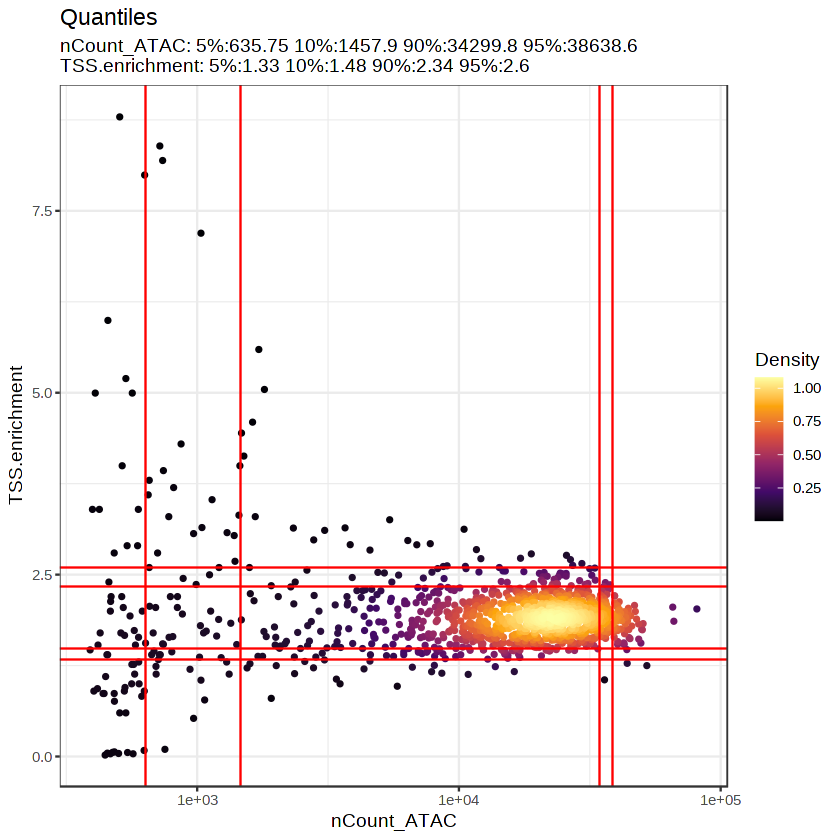

In [ ]:
DensityScatter(pbmc, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x =TRUE, quantile = TRUE)

The density plot shows the relationship between the number of accessible fragments detected per cell (nCount_ATAC) and transcription start site enrichment (TSS.enrichment).

- **Point density**: Areas with more intense colors indicate a higher concentration of cells with similar values.
- **Relationship**: Cells with more accessible fragments (X-axis) typically have higher TSS enrichment (Y-axis), suggesting greater transcriptional activity.
- **Cell quality**: Cells with low values on both axes may indicate low-quality cells.

This plot helps identify patterns and subpopulations of cells in scATAC-seq data.

### Fragment size distribution

Warning message:
"Removed 27 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


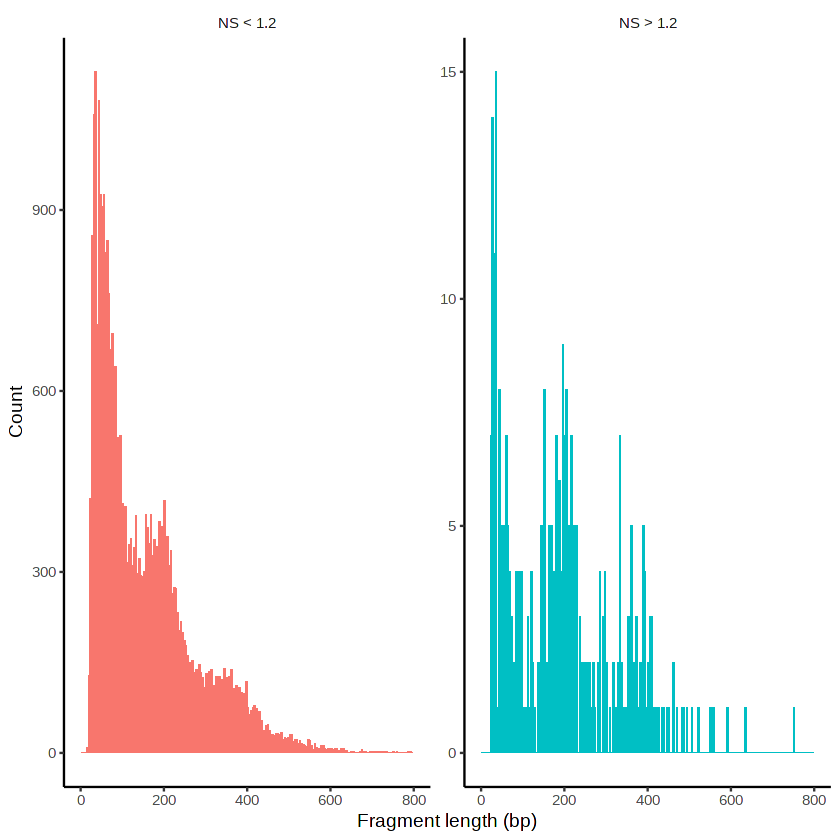

In [ ]:
pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 1.2, 'NS > 1.2', 'NS < 1.2')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')

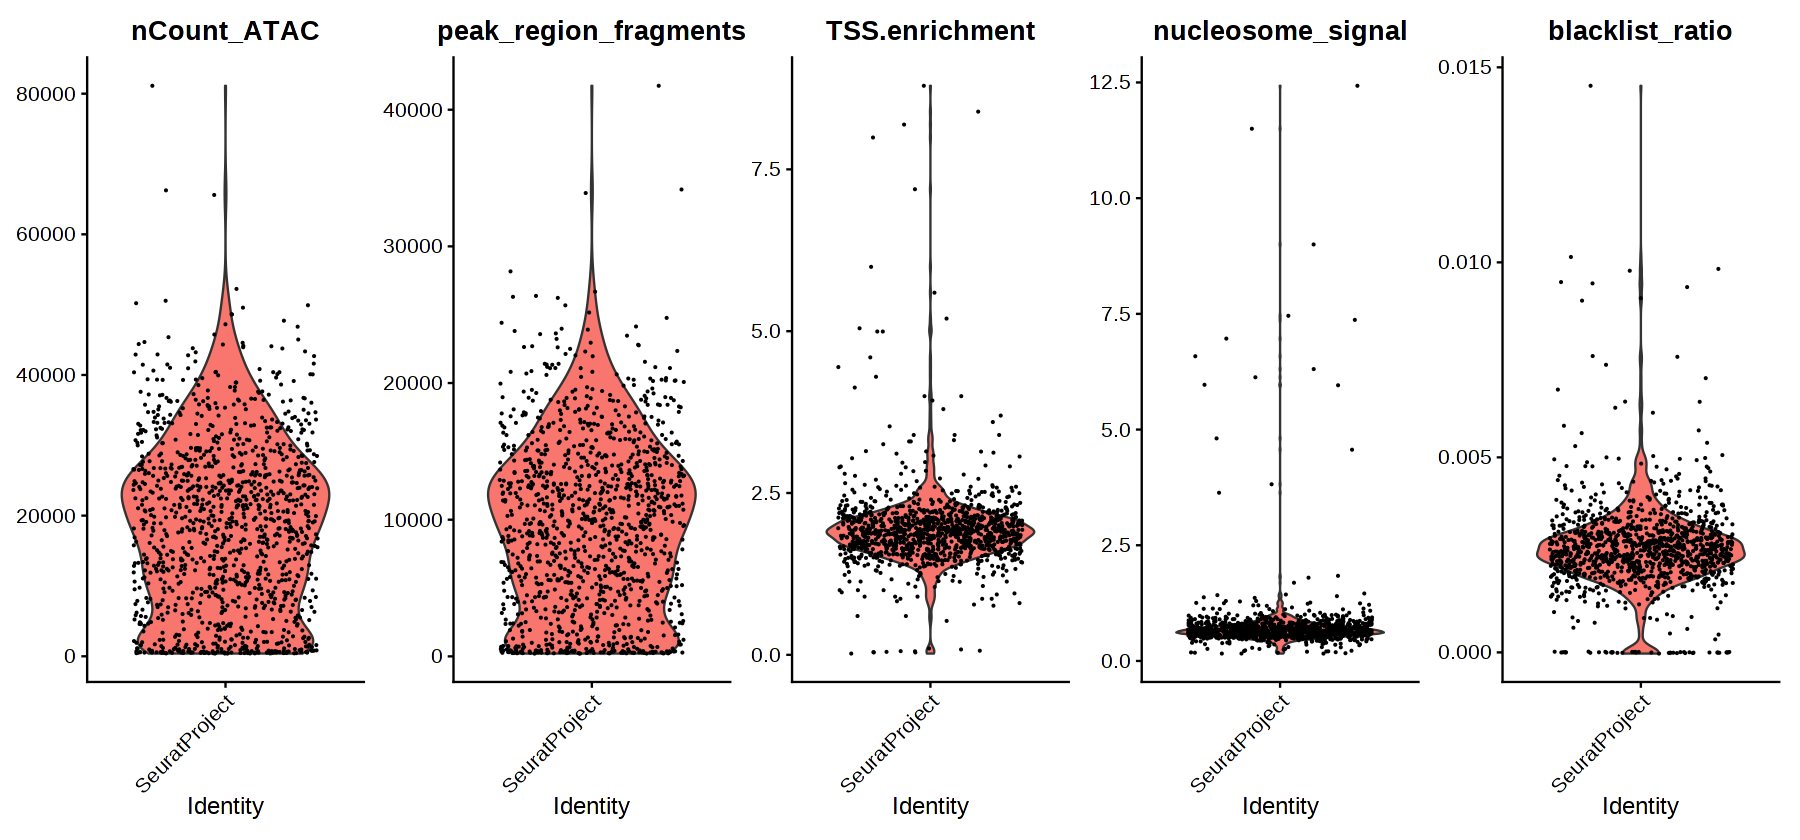

In [ ]:
# To change the screen size
options(repr.plot.width = 15, repr.plot.height = 7)

# plot
VlnPlot(
  object = pbmc,
  features = c("nCount_ATAC", "peak_region_fragments", "TSS.enrichment", "nucleosome_signal", "blacklist_ratio"),
  pt.size = 0.1,
  ncol = 5
)

Finally we remove cells that are outliers for these QC metrics.

In [ ]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    nCount_ATAC < 40000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 & # 15 % of the reads in the peaks
    blacklist_ratio < 0.05 & # 5 % of the reads mapeaning in blacklist ratio
    nucleosome_signal < 1.2 &
    TSS.enrichment > 1.5 # enrichment score
)
pbmc

An object of class Seurat 
48240 features across 837 samples within 1 assay 
Active assay: ATAC (48240 features, 0 variable features)
 2 layers present: counts, data

## 📘 Step 3: Normalization and linear dimensional reduction

- ✅ **Normalization:** Signac performs term frequency-inverse document frequency (TF-IDF) normalization. This is a two-step normalization procedure, that both normalizes across cells to correct for differences in cellular sequencing depth, and across peaks to give higher values to more rare peaks.

- ✅ **Feature selection:** The low dynamic range of scATAC-seq data makes it challenging to perform variable feature selection, as we do for scRNA-seq. Instead, we can choose to use only the top n% of features (peaks) for dimensional reduction, or remove features present in less than n cells with the FindTopFeatures() function. Here, we will all features, though we note that we see very similar results when using only a subset of features (try setting min.cutoff to ‘q75’ to use the top 25% all peaks), with faster runtimes. Features used for dimensional reduction are automatically set as VariableFeatures() for the Seurat object by this function.

- ✅ **Dimension reduction:** We next run singular value decomposition (SVD) on the TD-IDF matrix, using the features (peaks) selected above. This returns a reduced dimension representation of the object (for users who are more familiar with scRNA-seq, you can think of this as analogous to the output of PCA).

The combined steps of TF-IDF followed by SVD are known as latent semantic indexing (LSI), and were first introduced for the analysis of scATAC-seq data by Cusanovich et al. 2015.

https://stuartlab.org/signac/articles/pbmc_vignette#computing-qc-metrics

In [ ]:
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0')
pbmc <- RunSVD(pbmc)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



The first LSI component often captures sequencing depth (technical variation) rather than biological variation. If this is the case, the component should be removed from downstream analysis. We can assess the correlation between each LSI component and sequencing depth using the DepthCor() function:

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x09 in encoding latin1"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x09 in encoding latin1"


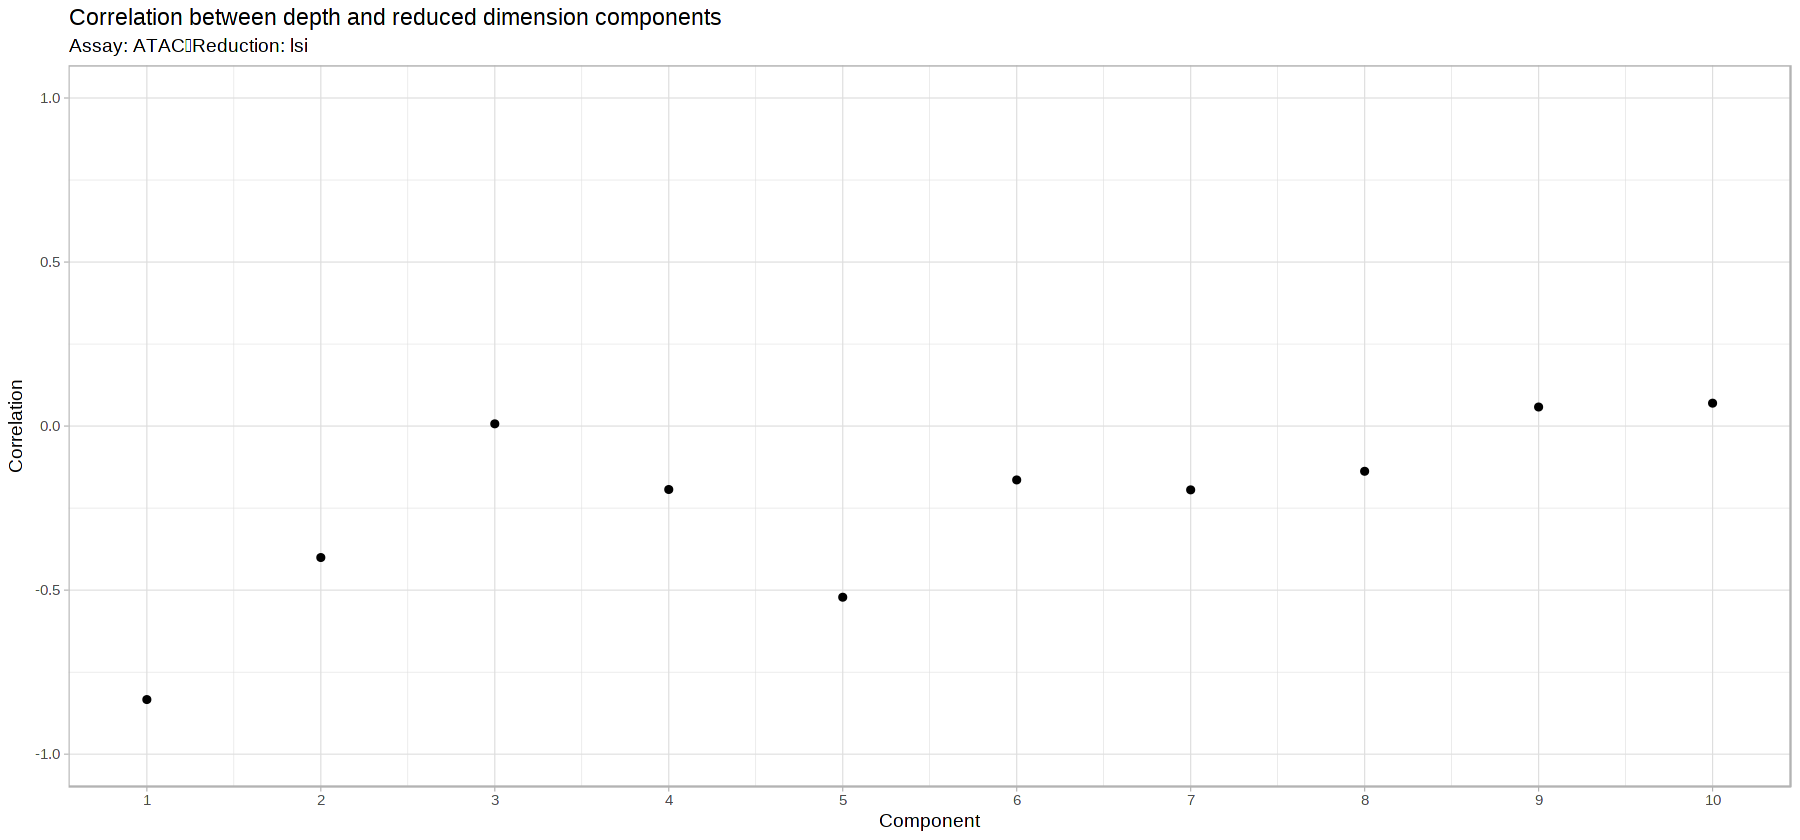

In [ ]:
DepthCor(pbmc)

Here we see there is a very strong correlation between the first LSI component and the total number of counts for the cell, so we will perform downstream steps without this component.

❌ Remove Component 1

Component 1 is often removed in dimensionality reduction analyses because it may capture non-biological variability or technical artifacts rather than biologically relevant patterns. Removing it helps focus on components that better reflect the true biological structure of the data.

## Check point ✔️

⚪ *As long as Google Colab keeps running:*

In [ ]:
# Save pbmc
save(pbmc, file = "pbmc_checkpoint.RData")

In [ ]:
# Clean all objects in the working environment
rm(list = ls())
gc()  # Free up memory

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,17087022,912.6,27376674,1462.1,27376674,1462.1
Vcells,72536144,553.5,183331923,1398.8,179800665,1371.8


In [ ]:
# Load the .RData file in the working environment
load("pbmc_checkpoint.RData")

Continued to “Step 4: Non-linear dimensional reduction and clustering”.

## 📙 Step 4: Non-linear dimensional reduction and clustering

Now that the cells are embedded in a low-dimensional space, we can use methods commonly applied for the analysis of scRNA-seq data to perform graph-based clustering and non-linear dimension reduction for visualization. The functions `RunUMAP()`, `FindNeighbors()`, and `FindClusters()` all come from the Seurat package.

In [ ]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE, algorithm = 3)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
20:36:26 UMAP embedding parameters a = 0.9922 b = 1.112

20:36:26 Read 837 rows and found 29 numeric columns

20:36:26 Using Annoy for neighbor search, n_neighbors = 30

20:36:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:36:26 Writing NN index file to temp file /tmp/RtmpVUHJOA/file227328a211

20:36:26 Searching Annoy index using 2 threads, search_k = 3000

20:36:26 Annoy recall = 100%

20:36:28 Commencing smooth kNN distance calibration using 2 threads
 with target n_neighbors = 

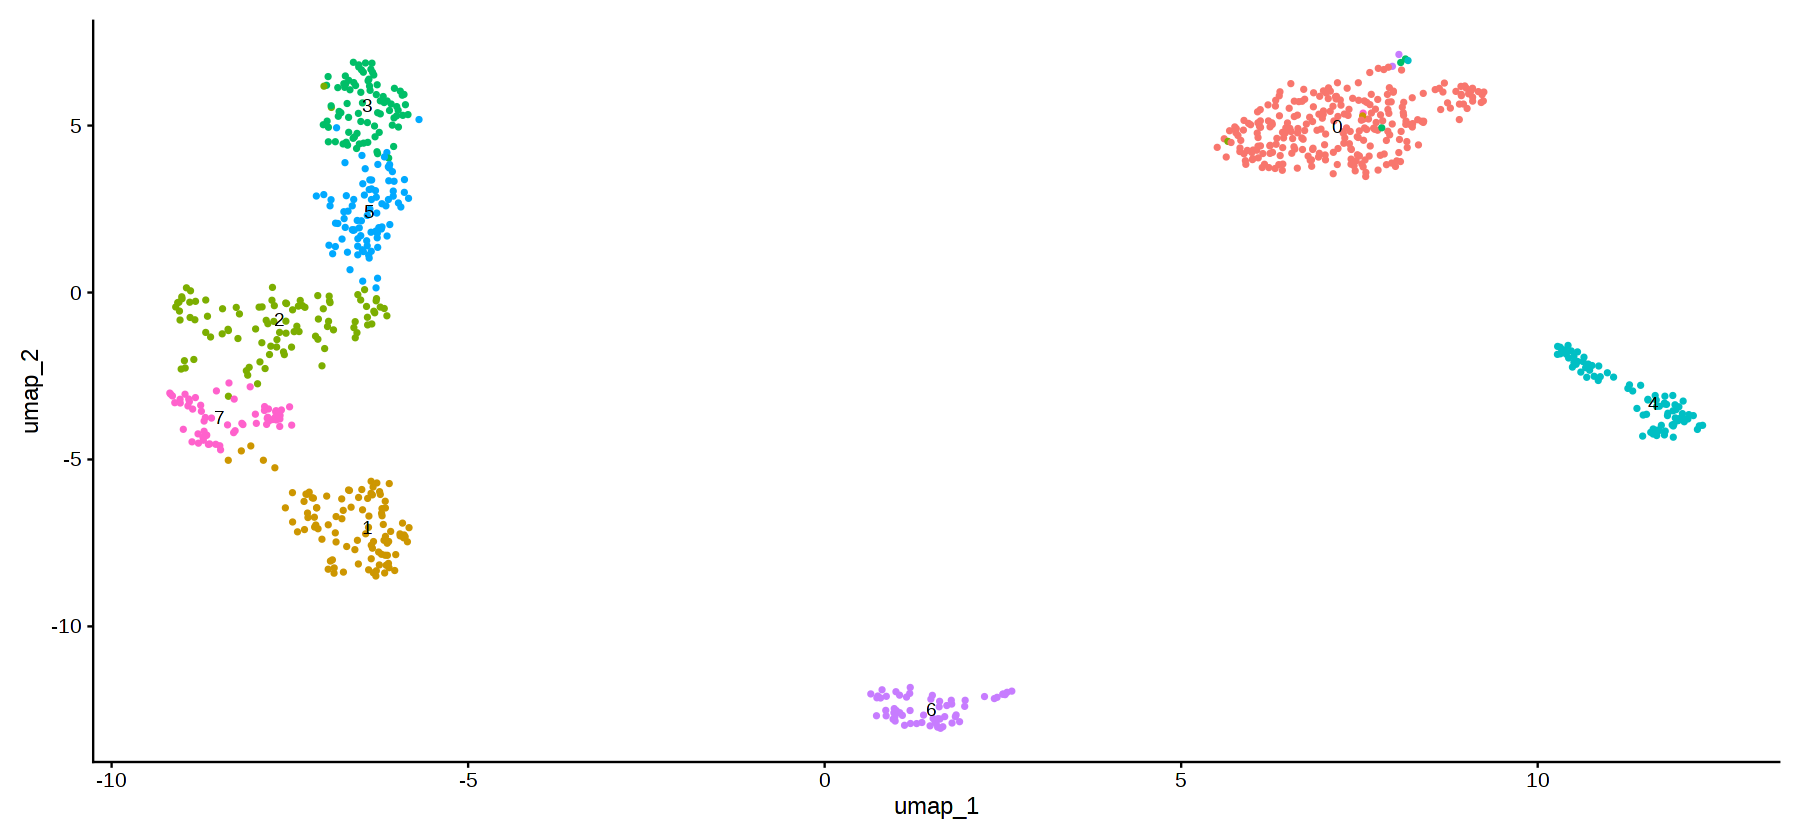

In [ ]:
DimPlot(object = pbmc, label = TRUE) + NoLegend()

In [ ]:
save(pbmc, file = "pbmc.RData")

The UMAP visualization reveals the presence of multiple cell groups in human blood.

At this point you have to download the output of this analysis to continue in the next practical tutorial.

# ☕ *Coffee break ☕ (30 min) - (10:30-11:00 h)*